## 说明
从文本内容分解开始的baseline数据

环境：（lenovo）base  
python = 3.7.6  
pytorch = 1.4.0  

In [1]:
import pandas as pd
import numpy as np
import math

import os
import logging
import time
import seaborn as sn
sn.set(style='darkgrid')

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import jieba
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchcrf import CRF    #This class provides an implementation of a CRF layer.
from torch.utils.data import Dataset,DataLoader, RandomSampler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'   #单个代码块显示全部输出

#%matplotlib auto    #画图弹出
%matplotlib inline   #画图内嵌

UsageError: unrecognized arguments: #画图内嵌


In [3]:
#各参数
trainPath = "./dataset/train_data_public.csv"
testPath = "./dataset/test_public.csv"
dicPath = "./dataset/vocab.txt"
log_path = './Logs/'
model_path = './Models/'
rq = time.strftime('%Y%m%d%H%M', time.localtime(time.time()))

#创建路径
if not os.path.exists(log_path):
    os.makedirs(log_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)

    
#第一步，创建一个logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Log等级总开关
if not logger.handlers:
    #创建一个handler，用于写入日志文件
    logfile = log_path + rq + '.log'   #log日志的文件名称
    
    filehandler = logging.FileHandler(logfile, mode='w')
    filehandler.setLevel(logging.DEBUG)  # 输出到file的log等级的开关
    
    streamhandler = logging.StreamHandler()
    streamhandler.setLevel(logging.DEBUG)  # 输出到console的log等级的开关
    
    # 第三步，定义handler的输出格式
    formatter = logging.Formatter("%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s")
    filehandler.setFormatter(formatter)
    streamhandler.setFormatter(formatter)

    # 第四步，将logger添加到handler里面
    logger.addHandler(filehandler)
    logger.addHandler(streamhandler)

# 日志
#logger.debug('this is a logger debug message')
#logger.info('this is a logger info message')
#logger.warning('this is a logger warning message')
#logger.error('this is a logger error message')
#logger.critical('this is a logger critical message')
#logger.removeHandler(fh)   #移除handler
#logger.handlers    #当前handler数

## 读取文件

In [4]:
if os.path.isfile(trainPath):
    print("file exist")
    dataset = pd.read_csv(trainPath)
logger.info('open train dataset,shape='+str(dataset.shape))
dataset   #共10000条数据，属性分为：unnamed，text，BIO_anno，class，bank_topic

2021-12-16 10:36:42,778 - <ipython-input-4-ee9c4350caf8>[line:4] - INFO: open train dataset,shape=(7528, 4)


file exist


,id,text,BIO_anno,class
0,0,交行14年用过，半年准备提额，却直接被降到1Ｋ，半年期间只T过一次三千，其它全部真实消费，第...,B-BANK I-BANK O O O O O O O O O O B-COMMENTS_N...,0
1,1,单标我有了，最近visa双标返现活动好,B-PRODUCT I-PRODUCT O O O O O O B-PRODUCT I-PR...,1
2,2,建设银行提额很慢的……,B-BANK I-BANK I-BANK I-BANK B-COMMENTS_N I-COM...,0
3,3,我的怎么显示0.25费率，而且不管分多少期都一样费率，可惜只有69k,O O O O O O O O O O B-COMMENTS_N I-COMMENTS_N ...,2
4,4,利率不错，可以撸,B-COMMENTS_N I-COMMENTS_N B-COMMENTS_ADJ I-COM...,1
...,...,...,...,...
7523,7523,我鼎级拒了,O O O B-COMMENTS_ADJ O,2
7524,7524,一打一个准，准胜，看激活信用卡时那协议，全是对银行有利的,O O O O O O O O O O B-COMMENTS_N I-COMMENTS_N ...,2
7525,7525,招行分期白80k,B-BANK I-BANK B-PRODUCT I-PRODUCT I-PRODUCT O O O,2
7526,7526,5万，额度还行吧没毕业哦,O O O B-COMMENTS_N I-COMMENTS_N O O O O O O O,2


In [5]:
#将数据集分为：训练集（70%），验证集（30%）
train_dataset,valid_dataset = train_test_split(dataset,test_size=0.3)
logger.info("训练集大小："+str(train_dataset.shape))
logger.info("验证集大小："+str(valid_dataset.shape))

2021-12-16 10:36:45,904 - <ipython-input-5-b51d8a0ac9d0>[line:3] - INFO: 训练集大小：(5269, 4)
2021-12-16 10:36:45,909 - <ipython-input-5-b51d8a0ac9d0>[line:4] - INFO: 验证集大小：(2259, 4)


## 数据内容分析

分析所有训练集的文本长度  
从下面的直方图中可以看出，文本的长度主要在20多，基本在100以后就没有了，因此可以把每条文本的固定长度MAX_LEN设置为100。

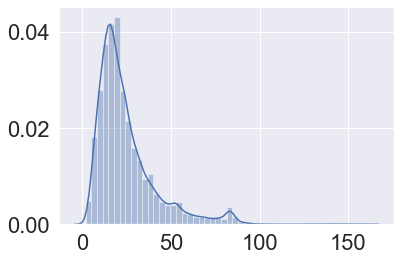

In [6]:
len_list = []
for index in range(dataset['text'].shape[0]):
    len_list.append(len(dataset['text'][index]))
#len_list
sn.set(font_scale=2)  #设置字体大小
sn.distplot(len_list)

统计每类标签的数目，画频次直方图，查看标签是否分布不均匀(标签O表示非标注标签，就不统计进去了)  
从频次直方图中可以看出，出现频次最高的是'I-PRODUCT',共有6000多次,频次最低的是'B-BANK'，共有不到2000次  
不过总的来说差距不算太悬殊，tag的分布可以说是较为均匀的

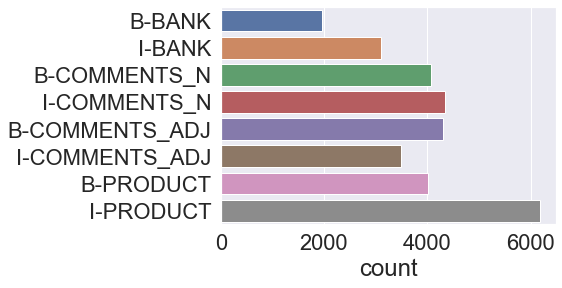

In [7]:
#把所有标签放进同一字符串中
strings = ''
for s in dataset['BIO_anno']:
    strings = strings+s
#创建list，去掉'O'
count_list = []
orig_count_list = strings.split()
for s in orig_count_list:
    if s.startswith('O')==False and s.endswith('O')==False and len(s)<15 and s!='I-BANKB-BANK': #这个数据集有很多无效标签
        count_list.append(s)

sn.countplot(y=count_list)

## 构建数据集输入合格式

In [ ]:
#train_dataset.head

In [8]:
MAX_LEN = 100    #句子的标准长度
BATCH_SIZE = 8  #minibatch的大小
EMBEDDING_DIM = 120
HIDDEN_DIM = 12

In [9]:
# 获取 tag to index 词典
def get_tag2index():
    return {"O": 0,
            "B-BANK":1,"I-BANK":2,         #银行实体
            "B-PRODUCT":3,"I-PRODUCT":4,   #产品实体
            "B-COMMENTS_N":5,"I-COMMENTS_N":6,   #用户评论，名词
            "B-COMMENTS_ADJ":7,"I-COMMENTS_ADJ":8    #用户评论，形容词
            }
# 获取 word to index 词典
def get_w2i(vocab_path = dicPath):
    w2i = {}
    with open(vocab_path, encoding = 'utf-8') as f:
        while True:
            text = f.readline()
            if not text:
                break
            text = text.strip()
            if text and len(text) > 0:
                w2i[text] = len(w2i) + 1
    return w2i

def pad2mask(t):
    if t==pad_index: #转换成mask所用的0
        return 0
    else:
        return 1

def text_tag_to_index(dataset):
    texts = []
    labels = []
    masks = []
    for row in range(len(dataset)):
        text = dataset.iloc[row]['text']
        tag = dataset.iloc[row]['BIO_anno']
        #text
        #tag
        if len(text)!=len(tag):  #如果从数据集获得的text和label长度不一致，就不要了？（那对验证会不会有影响）
            next

        #1. word转index
        #1.1 text词汇
        text_index = []
        text_index.append(start_index)   #先加入开头index
        for word in text:
            text_index.append(w2i.get(word, unk_index))   #将当前词转成词典对应index，或不认识标注UNK的index
        text_index.append(end_index)   #最后加个结尾index
        #index
        #1.2 tag标签
        tag = tag.split()
        tag_index = [tag2i.get(t,0) for t in tag]
        tag_index = [0] + tag_index + [0]

        #2. 填充或截至句子至标准长度
        #2.1 text词汇&tag标签
        if len(text_index)<MAX_LEN:    #句子短，补充pad_index到满够MAX_LEN
            pad_len = MAX_LEN-len(text_index)
            text_index = text_index + [pad_index]*pad_len
            tag_index = tag_index + [0]*pad_len
        elif len(text_index)>MAX_LEN:  #句子过长，截断
            text_index = text_index[:MAX_LEN-1]
            text_index.append(end_index)
            tag_index = tag_index[:MAX_LEN-1]
            tag_index.append(0)
        masks.append([pad2mask(t) for t in text_index])
        texts.append(text_index)
        labels.append(tag_index)
        
    #把list类型的转成tensor类型，方便后期进行训练
    texts = torch.LongTensor(texts)
    labels = torch.LongTensor(labels)
    masks = torch.tensor(masks, dtype=torch.uint8)
    return texts,labels,masks

class MiDataset(Dataset):
    def __init__(self, texts, labels, masks):
        self.dataset = texts #torch.tensor(texts)
        self.labels = labels    #torch.tensor(labels)
        self.masks = masks
        
        self.nums = len(self.dataset)
        
    def __getitem__(self, index):
        data = {'texts': self.dataset[index],
                'labels':self.labels[index],
                'masks':self.masks[index]}
        return data
    
    def __len__(self):
        return self.nums
    
#unk：未知词  pad：填充   start：文本开头   end：文本结束
unk_flag = '[UNK]'
pad_flag = '[PAD]'
start_flag = '[STA]'
end_flag = '[END]' 

w2i = get_w2i()   #获得word_to_index词典
tag2i = get_tag2index()    #获得tag_to_index词典

#w2i
unk_index = w2i.get(unk_flag, 101)
pad_index = w2i.get(pad_flag, 1)
start_index = w2i.get(start_flag, 102)    #开始
end_index = w2i.get(end_flag, 103)   #中间截至（主要用在有上下句的情况下）

In [10]:
#将训练集的字符全部转成index，并改成MAX_LEN长度
texts,labels,masks = text_tag_to_index(train_dataset)
texts.shape
labels.shape
masks.shape

#将数据集用MiDataset类包装
train_data = MiDataset(texts,labels,masks)
train_data

#train_sampler = RandomSampler(train_data)    #将训练集打乱
train_loader = DataLoader(dataset=train_data,   #按batch_size加载训练集
                                batch_size=BATCH_SIZE, 
                                #sampler=train_sampler,
                                num_workers=0,
                                shuffle=False,
                                drop_last=False)
train_loader

torch.Size([5269, 100])

torch.Size([5269, 100])

torch.Size([5269, 100])

In [11]:
#把第一个batch_data拿出来看看
for step, batch_data in enumerate(train_loader):
    print("step:"+str(step))
    batch_data['texts'].shape
    print("texts:"+str(batch_data['texts'][0].shape))
    batch_data['texts'][0]
    print("labels:"+str(batch_data['labels'][0].shape))
    batch_data['labels'][0]
    print("masks:"+str(batch_data['masks'][0].shape))
    batch_data['masks'][0]
    if step>=0:
        break

step:0


torch.Size([8, 100])

texts:torch.Size([100])


tensor([ 102, 1525, 7027, 2802, 6814, 3341, 8024, 3297, 6818, 3300, 1126,  702,
         122,  123,  122, 4638, 4510, 6413, 6963, 6158, 2882, 2779,  511, 6421,
         679,  833, 3221, 3855, 1355, 2802, 4638, 1416,  103,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1])

labels:torch.Size([100])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

masks:torch.Size([100])


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=torch.uint8)

## 构建模型

In [12]:
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, pad_index,batch_size):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.pad_idx = pad_index
        self.batch_size = batch_size
        
        #####中间层设置
        #embedding层
        self.word_embeds = nn.Embedding(vocab_size,embedding_dim,padding_idx=self.pad_idx)  #转词向量
        #lstm层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2, num_layers = 1, bidirectional = True)
        #LSTM的输出对应tag空间（tag space）
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)  #输入是[batch_size, size]中的size，输出是[batch_size，output_size]的output_size
        #CRF层
        self.crf = CRF(self.tagset_size)   #默认batch_first=False
        
        #lstm层的隐藏节点设置
        #hidden层的初始化似乎不能放在init里，得放在forward里：https://blog.csdn.net/qq_43473149/article/details/119490668
        #self.hidden = (torch.randn(2,self.batch_size,self.hidden_dim//2),torch.randn(2,self.batch_size,self.hidden_dim//2))#self.init_hidden()
    
   
    def forward(self, sentence, tags=None, mask=None):     #sentence=(batch,seq_len)   tags=(batch,seq_len)
        self.batch_size = sentence.shape[0]   #防止最后一batch中的数据量不够原本BATCH_SIZE
        #1. 从sentence到Embedding层
        embeds = self.word_embeds(sentence).permute(1,0,2)#.view(MAX_LEN,len(sentence),-1)   #output=[seq_len, batch_size, embedding_size]
        
        #2. 从Embedding层到BiLSTM层
        #隐藏层就是（h_0,c_0）   h_0的结构：(num_layers*num_directions,batch_size,hidden_size)=(2, 1, hidden_size=4//2=2)
        self.hidden = (torch.randn(2,self.batch_size,self.hidden_dim//2),torch.randn(2,self.batch_size,self.hidden_dim//2))  #修改进来 shape=((2,1,2),(2,1,2))  
        #input=(seq_length,batch_size,input_size)的张量  
        #output=(seq_length,batch_size,num_directions*hidden_size)=(MAX_LEN,batch_size, 2)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden) 
        
        #3. 从BiLSTM层到全连接层
        #从lstm的输出转为tagset_size长度的向量组（即输出了每个tag的可能性）
        #输出shape=(MAX_LEN, batch_size, len(tag_to_ix))
        lstm_feats = self.hidden2tag(lstm_out)   
        
        #4. 全连接层到CRF层
        if tags is not None: #训练用   #mask=attention_masks.byte()
            if mask is not None:
                loss = -1.*self.crf(emissions=lstm_feats,tags=tags.permute(1,0),mask=mask.permute(1,0),reduction='mean')   #outputs=(batch_size,)   输出log形式的likelihood
            else:
                loss = -1.*self.crf(emissions=lstm_feats,tags=tags.permute(1,0),reduction='mean')
            return loss
        else:   #测试用
            if mask is not None:
                prediction = self.crf.decode(emissions=lstm_feats,mask=mask.permute(1,0))   #mask=attention_masks.byte()
            else:
                prediction = self.crf.decode(emissions=lstm_feats)
            return prediction

In [21]:
#创建模型和优化器
model = BiLSTM_CRF(len(w2i), tag2i, EMBEDDING_DIM, HIDDEN_DIM,pad_index,BATCH_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
#显示模型基本参数
model

BiLSTM_CRF(
  (word_embeds): Embedding(21127, 120, padding_idx=1)
  (lstm): LSTM(120, 6, bidirectional=True)
  (hidden2tag): Linear(in_features=12, out_features=9, bias=True)
  (crf): CRF(num_tags=9)
)

## 训练

In [22]:
samples_cnt = texts.shape[0]
batch_cnt = math.ceil(samples_cnt/BATCH_SIZE)   #整除 向上取整
loss_list = []
for epoch in range(10):
    for step, batch_data in enumerate(train_loader):
        # 1. 清空梯度
        model.zero_grad()
        
        # 2. 运行模型
        loss = model(batch_data['texts'], batch_data['labels'],batch_data['masks']) 
        if step%100 ==0:
            logger.info('Epoch=%d  step=%d/%d  loss=%.5f' % (epoch,step,batch_cnt,loss))
        
        # 3. 计算loss值，梯度并更新权重参数                                 
        loss.backward()    #retain_graph=True)  #反向传播，计算当前梯度
        optimizer.step()  #根据梯度更新网络参数
    loss_list.append(loss)

2021-12-16 11:03:42,210 - <ipython-input-22-d0c282282fd8>[line:12] - INFO: Epoch=0  step=0/659  loss=81.40327
2021-12-16 11:03:52,443 - <ipython-input-22-d0c282282fd8>[line:12] - INFO: Epoch=0  step=100/659  loss=16.65938
2021-12-16 11:04:02,108 - <ipython-input-22-d0c282282fd8>[line:12] - INFO: Epoch=0  step=200/659  loss=17.39911
2021-12-16 11:04:11,671 - <ipython-input-22-d0c282282fd8>[line:12] - INFO: Epoch=0  step=300/659  loss=11.54819
2021-12-16 11:04:21,348 - <ipython-input-22-d0c282282fd8>[line:12] - INFO: Epoch=0  step=400/659  loss=10.79662
2021-12-16 11:04:30,915 - <ipython-input-22-d0c282282fd8>[line:12] - INFO: Epoch=0  step=500/659  loss=12.97041
2021-12-16 11:04:40,689 - <ipython-input-22-d0c282282fd8>[line:12] - INFO: Epoch=0  step=600/659  loss=7.47884
2021-12-16 11:04:46,811 - <ipython-input-22-d0c282282fd8>[line:12] - INFO: Epoch=1  step=0/659  loss=11.52219
2021-12-16 11:04:57,974 - <ipython-input-22-d0c282282fd8>[line:12] - INFO: Epoch=1  step=100/659  loss=8.1825

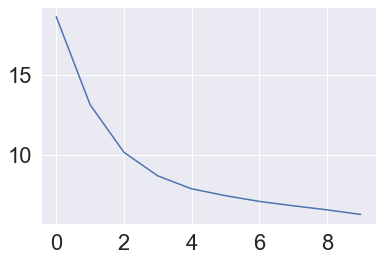

In [42]:
#折线图显示loss变化结果
loss_list_draw = [tensor.tolist() for tensor in loss_list]
sn.lineplot(x=range(len(loss_list_draw)),y=loss_list_draw,markers=True)

In [15]:
#保存训练结果
current_model_path = model_path+rq+"_model.pkl"
torch.save(model,current_model_path)
logger.info("保存模型文件："+current_model_path)

C:\Users\99655\anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
2021-12-16 10:53:37,930 - <ipython-input-15-673f61b68f8f>[line:4] - INFO: 保存模型文件：./Models/202112161036_model.pkl


In [ ]:
######加载已有的模型（默认加载最新保存模型）
for root, dirs, files in os.walk(model_path):
    #root    #当前目录
    #dirs    #当前目录下的子目录
    logger.info("当前已有模型文件："+str(files))   #当前目录下的非目录子文件
    load_model = files[-1]
    logger.info("加载最新模型文件："+str(load_model))
model = torch.load(model_path+load_model)
model

## 测试
用训练集中挑出的验证集部分进行测试

In [16]:
#batch_masks:tensor数据，结构为(batch_size,MAX_LEN)
#batch_labels: tensor数据，结构为(batch_size,MAX_LEN)
#batch_prediction:list数据，结构为(batch_size,)   #每个数据长度不一（在model参数mask存在的情况下）
def f1_score_evaluation(batch_masks,batch_labels,batch_prediction):
    all_prediction = []
    all_labels = []
    batch_size = batch_masks.shape[0]   #防止最后一batch的数据不够batch_size
    for index in range(batch_size):
        #把没有mask掉的原始tag都集合到一起
        length = sum(batch_masks[index].numpy()==1)
        _label = batch_labels[index].numpy().tolist()[:length]
        all_labels = all_labels+_label  
        #把没有mask掉的预测tag都集合到一起
        #_predict = y_pred[index][:length]
        all_prediction = all_prediction+y_pred[index]
        
        assert len(_label)==len(y_pred[index])
  
        
    assert len(all_prediction) == len(all_labels)
    score = f1_score(all_prediction,all_labels,average='weighted')
    
    return score

In [43]:
#将验证集的字符全部转成index，并改成MAX_LEN长度
test_texts,test_labels,test_masks = text_tag_to_index(valid_dataset)
test_texts.shape
test_labels.shape
test_masks.shape

#将数据集用MiDataset类包装
test_data = MiDataset(test_texts,test_labels,test_masks)
test_data

#train_sampler = RandomSampler(train_data)    #将训练集打乱
test_loader = DataLoader(dataset=test_data,   #按batch_size加载训练集
                                batch_size=BATCH_SIZE, 
                                #sampler=train_sampler,
                                num_workers=0,
                                shuffle=False,
                                drop_last=False)


torch.Size([2259, 100])

torch.Size([2259, 100])

torch.Size([2259, 100])

In [44]:
#把每个batch的数据都验证一遍，取均值
model.eval()   #不启用 BatchNormalization 和 Dropout，保证BN和dropout不发生变化
score_list = []
for step, batch_data in enumerate(test_loader):
    with torch.no_grad():   #这部分的代码不用跟踪反向梯度更新
        y_pred = model(sentence=batch_data['texts'],mask=batch_data['masks'])
        score = f1_score_evaluation(batch_masks=batch_data['masks'],
                                    batch_labels=batch_data['labels'],
                                    batch_prediction=y_pred)
        score_list.append(score)
#score_list
logger.info("average-f1-score:"+str(np.mean(score_list)))

BiLSTM_CRF(
  (word_embeds): Embedding(21127, 120, padding_idx=1)
  (lstm): LSTM(120, 6, bidirectional=True)
  (hidden2tag): Linear(in_features=12, out_features=9, bias=True)
  (crf): CRF(num_tags=9)
)

2021-12-16 11:28:25,679 - <ipython-input-44-b31fb016017c>[line:12] - INFO: average-f1-score:0.9360072236960136
